In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './preprocessed_data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_preprocessed.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_FUNCTION_PATH = os.path.join(DATA_PATH, 'score_function.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,NaN
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_genre_PCA
0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,"Documentary, Culture & Society, Gay, Gay Interest"
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...",Reporter,1956-12-19,F,NaN,NaN,Alice Barrett,43.0,"Horror, Drama, Slasher, Psychological thriller"


### 1.4 The score function

In [6]:
df_numbers=pd.read_csv(SCORE_FUNCTION_PATH, sep='\t')
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,0,0
1,Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,0,0


# 2. Features of movies computation

## 2.1 Number of actors per movie

In [7]:
#compute number of actors per movie
nb_actors_per_movie = df_chars['wikipedia_m_ID'].value_counts().reset_index().copy()
nb_actors_per_movie.rename({'wikipedia_m_ID': 'nb_actors', 'index': 'wikipedia_m_ID'}, axis=1, inplace=True)

In [8]:
#add nb of actors per movie
df_movies = df_movies.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()
df_chars = df_chars.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()

In [9]:
nb_unique_movies_in_movies = df_movies['wikipedia_m_ID'].nunique()
nb_unique_movies_in_chars = df_chars['wikipedia_m_ID'].nunique()
print("Number of unique movies in movies={} and in chars={} --> {}".format(nb_unique_movies_in_movies, nb_unique_movies_in_chars, nb_unique_movies_in_movies==nb_unique_movies_in_chars))

Number of unique movies in movies=24850 and in chars=24884 --> False


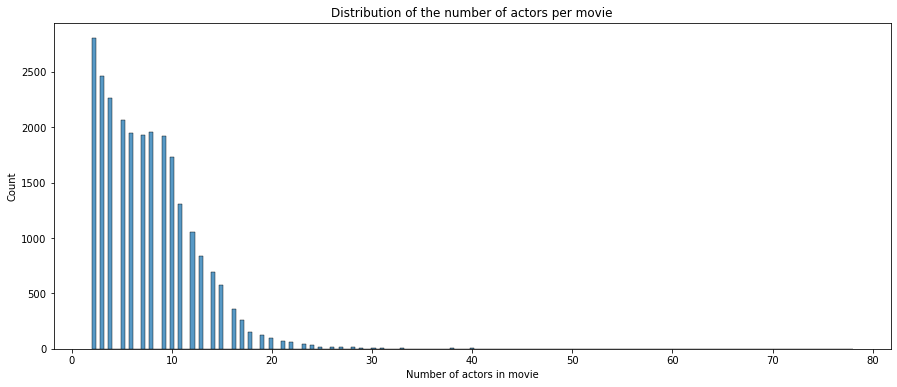

In average, there is 7.62 actors per movie among the american movies dataset with more than two actors.
There are 24850 unique movies which have a known list of actors greater than 2.


In [10]:
#nb actors per movie
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movies, x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors in movie")
plt.show()
avg_nb_actors_per_movie = df_movies['nb_actors'].mean()
nb_unique_movies_with_actors = df_movies['wikipedia_m_ID'].nunique()
print("In average, there is {:.2f} actors per movie among the american movies dataset with more than two actors.".format(avg_nb_actors_per_movie))
print("There are {} unique movies which have a known list of actors greater than 2.".format(nb_unique_movies_with_actors))

## 2.2 Number of movies of actor when releasing movie

In [11]:
#merge: if known score, column of score is = score, otherwise = 0
columns = df_numbers.columns
df_chars_numbers = df_chars.merge(df_numbers[columns[:-2]], on=['actor_name'], how='left').copy()
df_chars_numbers.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,42.750000,34.200000,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,1356.146032,2146.828571,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,645.500000,477.600000,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,764.333333,388.000000,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333


In [12]:
map_nb_movies_per_year = df_chars_numbers.groupby(['actor_name', 'm_release_year'])['wikipedia_m_ID'].count().reset_index()

In [13]:
year = range(1980, 2013)
list_nb_movies_at_year = dict()
for y in year:
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] < y)
    )
    list_nb_movies = map_nb_movies_per_year.loc[filter_conditions]
    list_nb_movies = list_nb_movies.groupby('actor_name')['wikipedia_m_ID'].sum()
    list_nb_movies_at_year.update({y: list_nb_movies})

In [14]:
def get_nb_movies_each_year(row):
    release_year = row['m_release_date'].year
    actor_name = row['actor_name']
    try:
        df_tmp = list_nb_movies_at_year[release_year]
        nb_movies = df_tmp[actor_name]
        return nb_movies
    except:
        return 0

In [15]:
df_chars_numbers['nb_movies_before_this_movie'] = df_chars_numbers.apply(lambda row: get_nb_movies_each_year(row), axis=1)

## 2.3 Number of movies per decade

In [16]:
nb_decades_lower = range(1980, 2030, 10)
nb_decades_upper = range(1990, 2030, 10)
list_decades = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] >= dec_lower)&
        (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] =list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [17]:
for key, dec in list_decades.items():
    df_chars_numbers = df_chars_numbers.merge(dec, on='actor_name', how='left')
    df_chars_numbers['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [18]:
df_chars_numbers.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2008,2009,2010,2011,2012,nb_movies_before_this_movie,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,NaN,NaN,NaN,NaN,NaN,3,0.0,2.0,4.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,19.0,17.1,15.545455,14.25,13.153846,8,0.0,3.0,6.0,0.0


## 2.4 Compute scores per actor at movie time

In [19]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [20]:
nb_unique_movies = df_chars_numbers['wikipedia_m_ID'].nunique()
print("There are {} unique movies with coacting.".format(nb_unique_movies))

There are 13712 unique movies with coacting.


In [21]:
def get_movie_actor_score(row):
    val = row[str(row['m_release_year']-1)]
    if val > 0:
        return val
    else:
        return 0

In [22]:
df_chars_numbers['actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

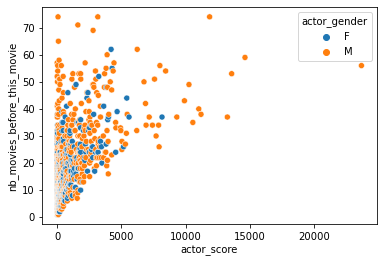

In [23]:
sns.scatterplot(data = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0)].sort_values('actor_score').drop_duplicates('actor_name', keep='last'), y='nb_movies_before_this_movie', x='actor_score', hue="actor_gender");

In [24]:
women_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']
men_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']

In [25]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had before performed 12.32 movies in average.
At the peak of their carreer, men had before performed 16.21 movies in average.


Ttest_indResult(statistic=-5.362465244255523, pvalue=9.619260122200605e-08)

In [26]:
women_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [27]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their carreer, women have in average reached a score of 525.89.
At the peak of their carreer, men have in average reached a score of 890.59.


Ttest_indResult(statistic=-4.022467941449092, pvalue=6.0723689662790975e-05)

## 3.6 Compute movie features

In [28]:
nb_unique_actors = df_chars_numbers['actor_name'].nunique()
print("There are {} unique actors with coacting.".format(nb_unique_actors))

There are 24701 unique actors with coacting.


In [29]:
df_chars_numbers.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2009,2010,2011,2012,nb_movies_before_this_movie,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020,actor_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,NaN,NaN,NaN,NaN,3,0.0,2.0,4.0,0.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,17.1,15.545455,14.25,13.153846,8,0.0,3.0,6.0,0.0,171.0


In [30]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_score']
df_temp = df_chars_numbers.copy()
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_movies_features = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join,'actor_gender':'$l$'.join, 'actor_score':'$l$'.join})

In [31]:
df_movies_features

,actor_name,actor_gender,actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....
3947,Isabella Rossellini$l$Kyle MacLachlan$l$Dennis...,F$l$M$l$M$l$F$l$F$l$M$l$M$l$F$l$F$l$M$l$M,0.0$l$34.5$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0...
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,F$l$M$l$M$l$M$l$M$l$F$l$M$l$M$l$M$l$M$l$F$l$F$...,0.0$l$0.0$l$11.571428571428571$l$15.7142857142...
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,M$l$M$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$...,0.0$l$0.0$l$0.0$l$0.0$l$2844.061904761905$l$0....
...,...,...,...
36619262,Leonardo Nam$l$Gillian Jacobs$l$Peter Scanavino,M$l$F$l$M,0.0$l$0.0$l$0.0
36724042,John Barrowman$l$Ryan Cutrona$l$Bashar Rahal,M$l$M$l$M,0.0$l$0.0$l$0.0
36956792,Bruce Allpress$l$Ben Chaplin$l$Brian Cox$l$Ale...,M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$F$l$F,0.0$l$4.666666666666667$l$0.0$l$0.0$l$0.0$l$0....


In [32]:
def get_function_of_list_values(list_values, function, gender=None):
    list_split = list_values.split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [33]:
def get_function_of_list_values_condition(row, function, gender_cat=None):
    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    list_split = []
    for x, gender in zip(list_temp, gender_split):
        if gender == gender_cat:
            list_split.append(x)
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        try:
            return (np.count_nonzero(list_split))/np.count_nonzero(list_temp)
        except:
            return 0

In [34]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_movies_features['score_'+f] = df_movies_features['actor_score'].apply(lambda x: get_function_of_list_values(x, f))

In [35]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_movies_features[gender+'_'+f] = df_movies_features.apply(lambda row: get_function_of_list_values_condition(row, f, gender), axis=1)


In [36]:
df_movies_features.head()

,actor_name,actor_gender,actor_score,score_max,score_min,score_mean,score_median,score_nb_famous_actors,score_prop_famous_actors,M_max,...,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,F_max,F_min,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors
wikipedia_m_ID,,,,,,,,,,,,,,,,,,,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...,0.000000,0.0,0.000000,0.0,0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....,250.000000,0.0,19.230769,0.0,1,0.076923,250.000000,...,25.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3947,Isabella Rossellini$l$Kyle MacLachlan$l$Dennis...,F$l$M$l$M$l$F$l$F$l$M$l$M$l$F$l$F$l$M$l$M,0.0$l$34.5$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0...,34.500000,0.0,3.136364,0.0,1,0.090909,34.500000,...,5.750000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,F$l$M$l$M$l$M$l$M$l$F$l$M$l$M$l$M$l$M$l$F$l$F$...,0.0$l$0.0$l$11.571428571428571$l$15.7142857142...,15.714286,0.0,1.948980,0.0,2,0.142857,15.714286,...,3.031746,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,M$l$M$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$...,0.0$l$0.0$l$0.0$l$0.0$l$2844.061904761905$l$0....,2844.061905,0.0,189.604127,0.0,1,0.066667,2844.061905,...,218.773993,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Actors dataset preparation

In [37]:
list_columns = ['score_'+x for x in list_function_score] + ['F_'+x for x in list_function_score] + ['M_'+x for x in list_function_score]

In [38]:
df_chars_merged = df_chars_numbers.merge(df_movies_features[list_columns], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333


#### Booleans for revelation and famous

In [39]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,Ghosts of Mars,...,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,Ghosts of Mars,...,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333,0,1


#### Filter out actors when movie released date was after his·her revelation

In [40]:
filter_conditions = (
    (df_chars_merged['already_revealed'] == 0)    

)
df_chars_filtered = df_chars_merged.loc[filter_conditions]

#### Mapping past of actor

In [41]:
aggregation = {"score_max":"max", "score_mean":"mean", "score_prop_famous_actors":"mean", "score_prop_famous_actors":"max", "score_nb_famous_actors":"max"}
map_past_of_actor = df_chars_filtered.groupby(['actor_name', 'm_release_year']).agg(aggregation).reset_index()

In [42]:
year = range(1982, 2013)
#columns = ["score_max", "score_mean", "score_prop_famous_actors", "score_prop_famous_actors", "score_nb_famous_actors"]
list_past_actors_per_year = pd.DataFrame()
for y in year:
    filter_conditions = (
        (map_past_of_actor['m_release_year'] >= y-3) &
        (map_past_of_actor['m_release_year'] <= y)
    )
    list_past_actors = map_past_of_actor.loc[filter_conditions].copy()
    list_past_actors = list_past_actors.groupby('actor_name').agg(aggregation)
    previous_col = list_past_actors.columns
    list_past_actors.columns = ['previous_'+c for c in previous_col]
    list_past_actors['m_release_year'] = list_past_actors.apply(lambda row: y, axis=1)
    list_past_actors_per_year = pd.concat([list_past_actors_per_year, list_past_actors])

list_past_actors_per_year.reset_index(inplace=True)

In [43]:
df_final = df_chars_filtered.merge(list_past_actors_per_year, on=['actor_name', 'm_release_year'], how='left')

#### Filter out movies where no one in the current casting and in the previous castings were famous

In [44]:
df_final = df_final[~((df_final['score_nb_famous_actors']==0) & (df_final['previous_score_nb_famous_actors']==0))].copy()

In [45]:
df_final.drop_duplicates(['actor_name', 'm_release_year'], inplace=True)

# 4. Actor revelation prediction

In [46]:
df_final['actor_name'].nunique()

18243

In [47]:
df_final['is_revealed'].value_counts()

0    58118
1     1376
Name: is_revealed, dtype: int64

## 4.1 Average per past feature and revelation movie feature

In [48]:
df_final.groupby('is_revealed').mean()

,wikipedia_m_ID,actor_height,actor_age,m_release_year,min_year,nb_actors,1980,1981,1982,1983,...,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,already_revealed,previous_score_max,previous_score_mean,previous_score_prop_famous_actors,previous_score_nb_famous_actors
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,9.820502e+06,1.823185,39.061215,1999.876596,1960.557007,11.994460,0.0,0.000000,0.378610,0.946096,...,0.344278,104.679658,4.168729,1.456269,0.564214,0.0,1757.766516,86.811552,0.256143,3.299963
1,7.300334e+06,1.747725,31.999264,1998.699855,1998.699855,13.634448,0.0,2.021802,2.813953,7.210635,...,0.045576,154.531012,6.880355,1.881455,0.629330,0.0,2760.648697,107.395163,0.304185,4.384558


<AxesSubplot:xlabel='is_revealed', ylabel='score_prop_famous_actors'>

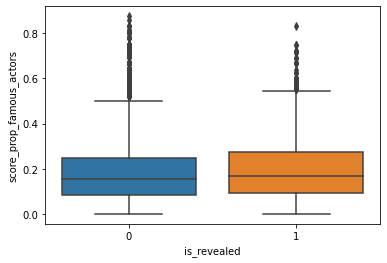

In [49]:
sns.boxplot(data=df_final, x='is_revealed',y='score_prop_famous_actors')

<AxesSubplot:xlabel='is_revealed', ylabel='previous_score_prop_famous_actors'>

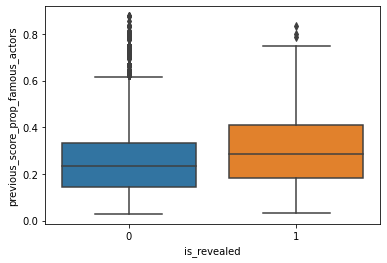

In [50]:
sns.boxplot(data=df_final, x='is_revealed',y='previous_score_prop_famous_actors')

<AxesSubplot:xlabel='is_revealed', ylabel='score_max'>

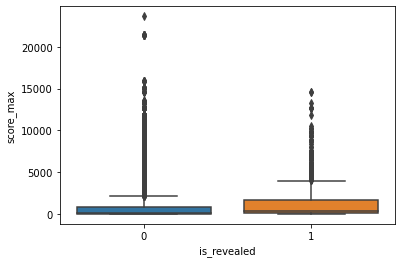

In [51]:
sns.boxplot(data=df_final, x='is_revealed',y='score_max')

<AxesSubplot:xlabel='is_revealed', ylabel='previous_score_max'>

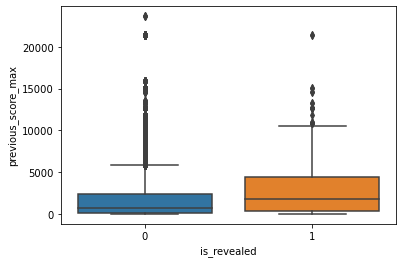

In [52]:
sns.boxplot(data=df_final, x='is_revealed',y='previous_score_max')

## 4.2 Correlation

In [53]:
list_columns = ['score_max', 'score_min','score_mean', 'score_median', 'score_nb_famous_actors',
                'score_prop_famous_actors', 'F_max', 'F_min', 'F_mean', 'F_median',
                'F_nb_famous_actors', 'F_prop_famous_actors', 'M_max', 'M_min',
                'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors', 'previous_score_max',
                'previous_score_mean', 'previous_score_prop_famous_actors',
                'previous_score_nb_famous_actors', 'is_revealed']

In [54]:
list_columns = ['score_max', 'score_nb_famous_actors',
                'score_prop_famous_actors', 'previous_score_max',
                'previous_score_mean', 'previous_score_prop_famous_actors',
                'previous_score_nb_famous_actors','m_release_year', 'is_revealed']

In [55]:
list_columns = ['score_max', 'score_nb_famous_actors',
                'score_prop_famous_actors', 'm_release_year', 'is_revealed']

<AxesSubplot:xlabel='nb_movies_before_this_movie', ylabel='Count'>

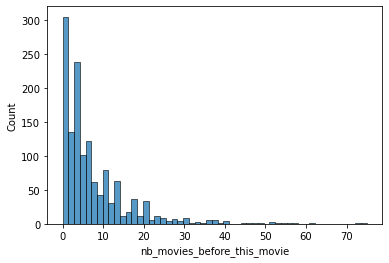

In [56]:
sns.histplot(data=df_final[df_final['is_revealed'] == 1], x='nb_movies_before_this_movie')

<AxesSubplot:>

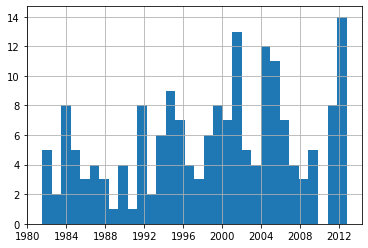

In [57]:
df_final.loc[(df_final['is_revealed'] == 1) & (df_final['nb_movies_before_this_movie'] == 0)]['m_release_date'].hist(bins=32)

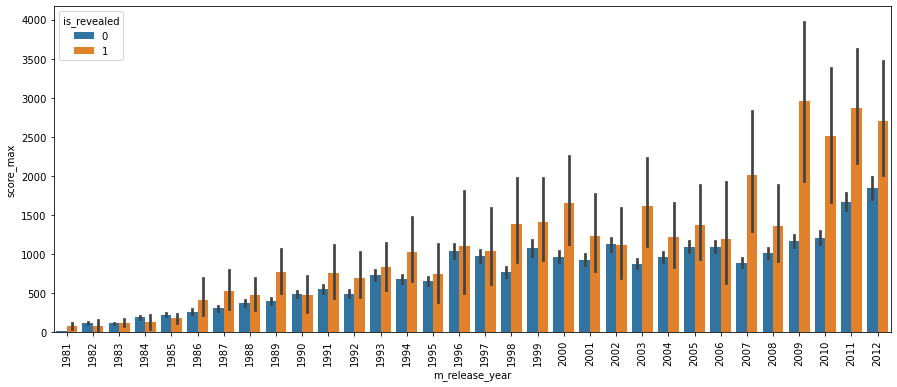

In [58]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='score_max', hue='is_revealed')
plt.xticks(rotation=90);

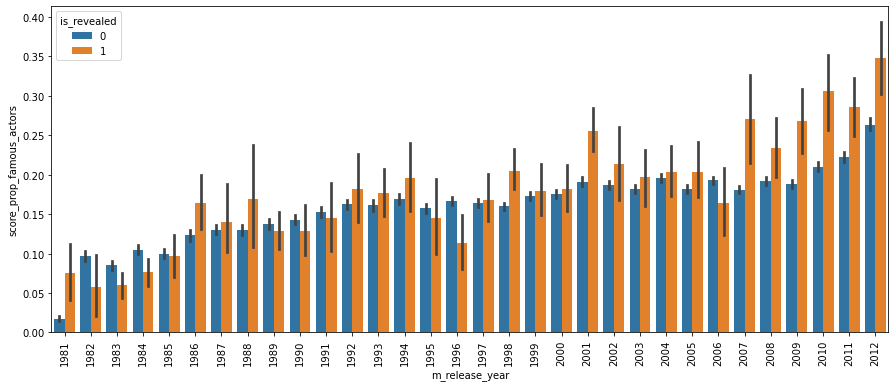

In [59]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='score_prop_famous_actors', hue='is_revealed')
plt.xticks(rotation=90);

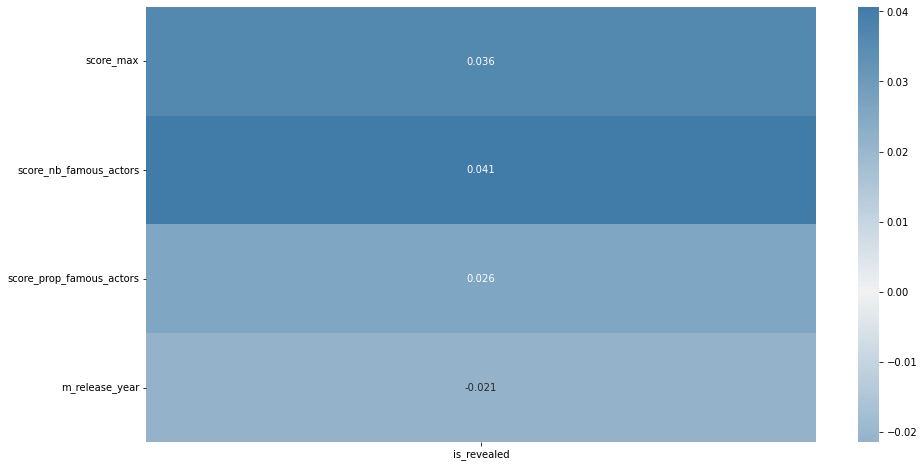

In [60]:
columns = list_columns
dataset = df_final[columns].fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
corr.drop(corr.tail(1).index,inplace=True)
#mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr[['is_revealed']], cmap=cmap, center=0, annot=True)
plt.show()

In [61]:
revealed_ = df_final[df_final['is_revealed'] == 1]
not_revealed_ = df_final[df_final['is_revealed'] == 0]
ttest_ind(revealed_['score_prop_famous_actors'], not_revealed_['score_prop_famous_actors'])

Ttest_indResult(statistic=6.384098134642077, pvalue=1.7367650673118204e-10)

In [62]:
ttest_ind(revealed_['score_max'], not_revealed_['score_max'])

Ttest_indResult(statistic=8.904430220128871, pvalue=5.513268092004895e-19)

In [63]:
ttest_ind(revealed_['score_nb_famous_actors'], not_revealed_['score_nb_famous_actors'])

Ttest_indResult(statistic=9.915220167777838, pvalue=3.7257439589155187e-23)

## 4.3 Zoom on actors for which their revelation was at their first movie

In [64]:
#select only the ones for which the revelation was at their first movie
revelation_at_first_movie = df_final.loc[(df_final['nb_movies_before_this_movie'] == 0)]

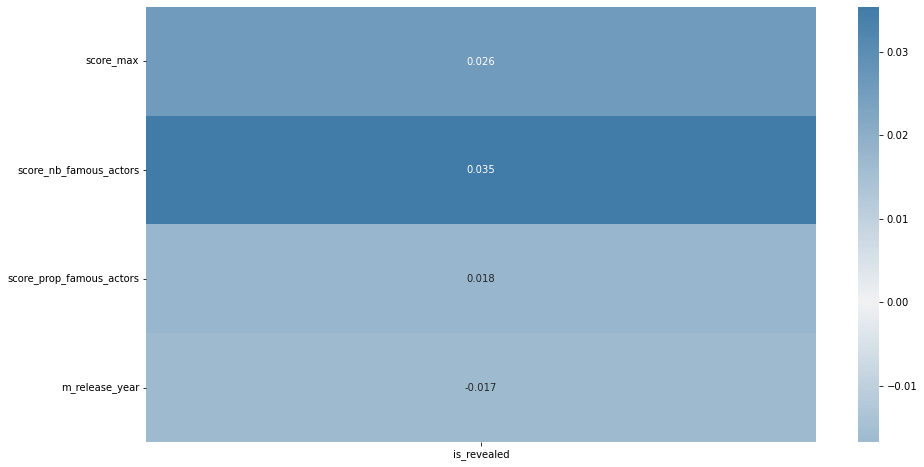

In [65]:
columns = list_columns
dataset = revelation_at_first_movie[columns].fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
corr.drop(corr.tail(1).index,inplace=True)
#mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr[['is_revealed']], cmap=cmap, center=0, annot=True)
plt.show()

In [66]:
revelation_at_first_movie.groupby(['is_revealed']).mean()

,wikipedia_m_ID,actor_height,actor_age,m_release_year,min_year,nb_actors,1980,1981,1982,1983,...,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,already_revealed,previous_score_max,previous_score_mean,previous_score_prop_famous_actors,previous_score_nb_famous_actors
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,8.783374e+06,1.779011,30.982563,1999.680318,1949.377826,12.724363,0.0,0.000000,0.690332,2.395015,...,0.410208,116.339983,4.660476,1.576102,0.652016,0.0,1109.590949,101.634140,0.198776,2.508039
1,6.367551e+06,1.729962,21.488889,1998.538462,1998.538462,14.049451,0.0,1.857143,0.928571,5.800366,...,0.000000,148.832037,3.176529,1.961538,0.674817,0.0,1655.758339,139.235104,0.228679,3.248588


In [67]:
revelation_at_first_movie.groupby(['m_release_year', 'is_revealed']).mean()

wikipedia_m_ID  actor_height  actor_age  \
m_release_year is_revealed                                            
1981           0              8.146164e+06      1.751910  30.567485   
               1              3.700303e+06      1.675667  27.200000   
1982           0              6.456874e+06      1.714594  33.653333   
1983           0              4.512391e+06      1.774408  32.991379   
               1              8.685666e+06      1.700000  25.000000   
...                                    ...           ...        ...   
2010           1              2.424935e+07      1.750000  15.500000   
2011           0              2.819469e+07      1.725079  31.621749   
               1              2.765670e+07      1.742857  27.100000   
2012           0              3.025628e+07      1.726692  32.440945   
               1              3.183310e+07      1.633333  24.800000   

                               min_year  nb_actors  1980  1981       1982  \
m_release_year is_revealed                                                  
1981           0            1989.081081   9.053892   0.0   0.0  13.057143   
               1            1981.000000   9.600000   0.0  67.6  33.800000   
1982           0            1990.250000  12.868421   0.0   0.0   0.000000   
1983           0            1875.705882  13.632479   0.0   0.0   0.000000   
               1            1983.000000  12.250000   0.0   0.0   0.000000   
...                                 ...        ...   ...   ...        ...   
2010           1            2010.000000  13.500000   0.0   0.0   0.000000   
2011           0            1831.818182  13.505669   0.0   0.0   0.000000   
               1            2011.000000  12.400000   0.0   0.0   0.000000   
2012           0            1511.437500  13.074906   NaN   NaN        NaN   
               1            2012.000000  11.900000   0.0   0.0   0.000000   

                                  1983       1984  ...     M_min      M_mean  \
m_release_year is_revealed                         ...                         
1981           0             41.157143   38.52381  ...  0.000000    1.967591   
               1             38.533333  116.90000  ...  0.000000   27.072857   
1982           0             18.125000   52.06250  ...  0.000000   15.547941   
1983           0              0.000000    0.00000  ...  0.000000   18.727097   
               1            215.750000  107.87500  ...  0.000000   22.694444   
...                                ...        ...  ...       ...         ...   
2010           1              0.000000    0.00000  ...  0.000000  720.613025   
2011           0              0.000000    0.00000  ...  0.000000  193.210291   
               1              0.000000    0.00000  ...  0.000000  598.824382   
2012           0                   NaN        NaN  ...  0.172512  240.604681   
               1              0.000000    0.00000  ...  0.000000  294.507184   

                             M_median  M_nb_famous_actors  \
m_release_year is_revealed                                  
1981           0             0.868263            0.101796   
               1             0.000000            0.800000   
1982           0             0.000000            1.026316   
1983           0             1.074074            1.034188   
               1             0.000000            0.750000   
...                               ...                 ...   
2010           1             0.000000            3.500000   
2011           0             7.232894            1.961364   
               1            13.735088            3.600000   
2012           0            25.373683            2.217228   
               1             3.286667            2.500000   

                            M_prop_famous_actors  already_revealed  \
m_release_year is_revealed                                           
1981           0                        0.077844               0.0   
               1                        0.700000         

<AxesSubplot:xlabel='is_revealed', ylabel='score_prop_famous_actors'>

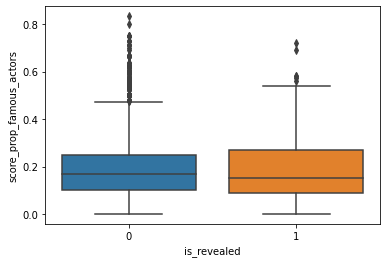

In [68]:
sns.boxplot(data=revelation_at_first_movie, x='is_revealed', y='score_prop_famous_actors')

In [69]:
revealed_at_first_movie = revelation_at_first_movie[revelation_at_first_movie['is_revealed'] == 1]
not_revealed_at_first_movie = revelation_at_first_movie[revelation_at_first_movie['is_revealed'] == 0]
ttest_ind(revealed_at_first_movie['score_prop_famous_actors'], not_revealed_at_first_movie['score_prop_famous_actors'])

Ttest_indResult(statistic=1.9623609921086, pvalue=0.04974326851925275)

In [70]:
ttest_ind(revealed_at_first_movie['score_max'], not_revealed_at_first_movie['score_max'])

Ttest_indResult(statistic=2.8609403358600147, pvalue=0.004231074881190308)

In [71]:
ttest_ind(revealed_at_first_movie['score_nb_famous_actors'], not_revealed_at_first_movie['score_nb_famous_actors'])

Ttest_indResult(statistic=3.900621805497332, pvalue=9.646292594792792e-05)

## 4.3 Prediction

In [72]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='liblinear', max_iter=10000, C=1, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 58.36%


In [73]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.65      0.99      0.79      2375
           1       0.54      0.02      0.04      1270

    accuracy                           0.65      3645
   macro avg       0.60      0.51      0.41      3645
weighted avg       0.62      0.65      0.53      3645



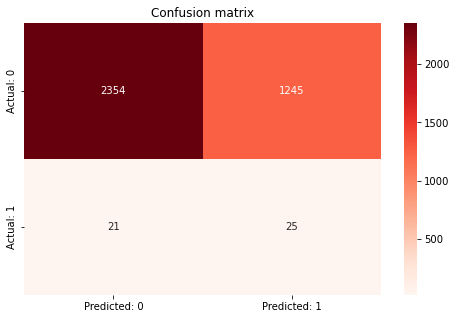

In [74]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

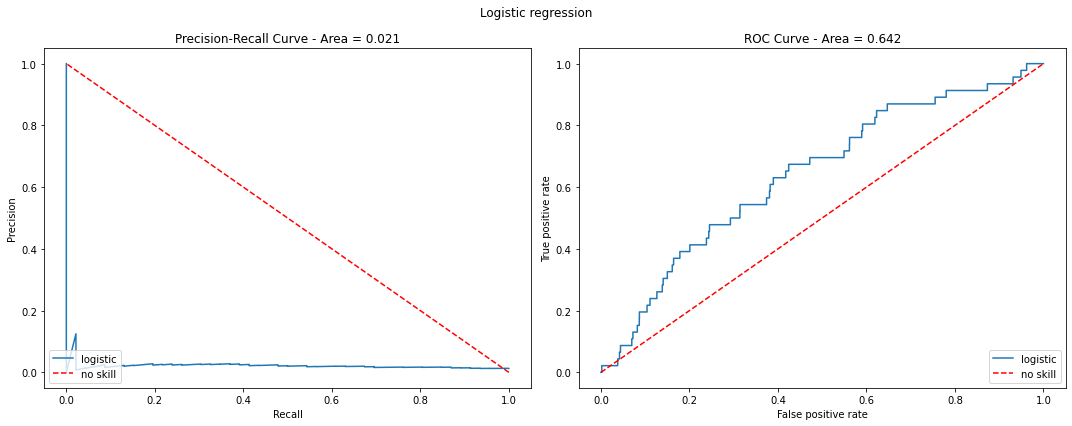

In [75]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

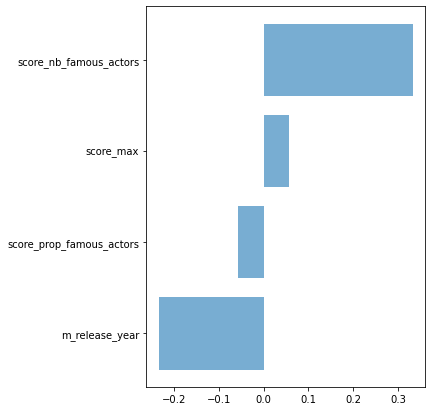

In [76]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 5. Movie revelation prediction

## 5.1 Grouping movies by actors

In [77]:
df_movie_revelation = df_final.groupby('wikipedia_m_ID')['is_revealed'].sum().copy().reset_index()
df_movie_revelation.rename({'is_revealed' : 'has_revelation'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,has_revelation
0,3746,1
1,3947,0
2,4231,0
3,4560,0
4,4726,0


In [78]:
df_movie_revelation['has_revelation'].value_counts()

0    10878
1      949
Name: has_revelation, dtype: int64

In [79]:
df_chars_revelation = df_final.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [80]:
df_revelation = df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')

In [81]:
df_revelation = df_revelation[df_revelation['score_nb_famous_actors'] > 0].copy()

In [82]:
df_revelation.groupby('has_revelation').mean()

,wikipedia_m_ID,actor_height,actor_age,m_release_year,min_year,nb_actors,1980,1981,1982,1983,...,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,is_revealed,already_revealed,previous_score_max,previous_score_mean,previous_score_prop_famous_actors,previous_score_nb_famous_actors
has_revelation,,,,,,,,,,,,,,,,,,,,,
0,1.066139e+07,1.753816,38.519508,2000.543421,1951.982990,10.128400,0.0,0.000000,0.000000,0.000000,...,131.478926,13.848070,1.588830,0.676116,0.0,0.0,1870.838265,98.553096,0.302877,3.377802
1,7.650263e+06,1.747865,32.014833,1999.855055,1999.855055,13.589525,0.0,1.046285,2.415956,4.002842,...,179.458786,7.201728,2.121803,0.696955,1.0,0.0,3171.821531,119.219135,0.331984,4.809113


<AxesSubplot:xlabel='has_revelation', ylabel='score_prop_famous_actors'>

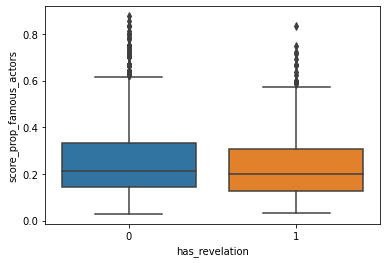

In [83]:
sns.boxplot(data=df_revelation, x='has_revelation',y='score_prop_famous_actors')

In [84]:
df_revelation.groupby('has_revelation')['M_prop_famous_actors'].mean()

has_revelation
0    0.676116
1    0.696955
Name: M_prop_famous_actors, dtype: float64

In [85]:
df_revelation.groupby('has_revelation')['F_prop_famous_actors'].mean()

has_revelation
0    0.341249
1    0.306403
Name: F_prop_famous_actors, dtype: float64

In [86]:
list_columns = ['score_max',
 'score_nb_famous_actors',
 'score_prop_famous_actors',
 'previous_score_max',
 'previous_score_mean',
 'previous_score_prop_famous_actors',
 'previous_score_nb_famous_actors',
 'm_release_year']

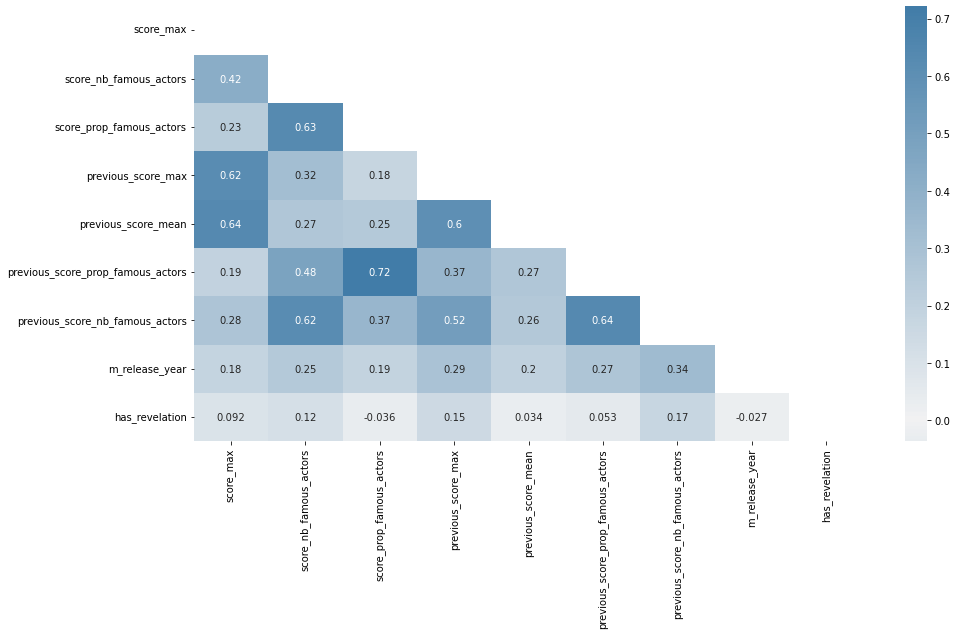

In [87]:
columns = list_columns+['wikipedia_m_ID', 'actor_name', 'has_revelation']
dataset = df_revelation[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [88]:
X = dataset.drop('has_revelation', axis=1)
y = dataset['has_revelation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 67.45%


In [89]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      1638
         1.0       0.67      0.21      0.32       782

    accuracy                           0.71      2420
   macro avg       0.69      0.58      0.57      2420
weighted avg       0.70      0.71      0.65      2420



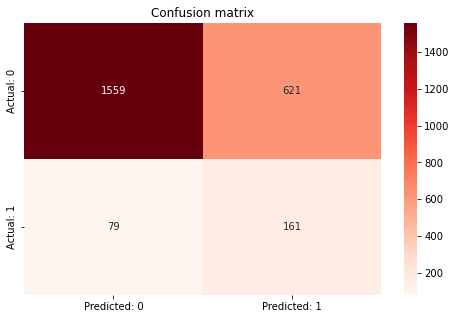

In [90]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

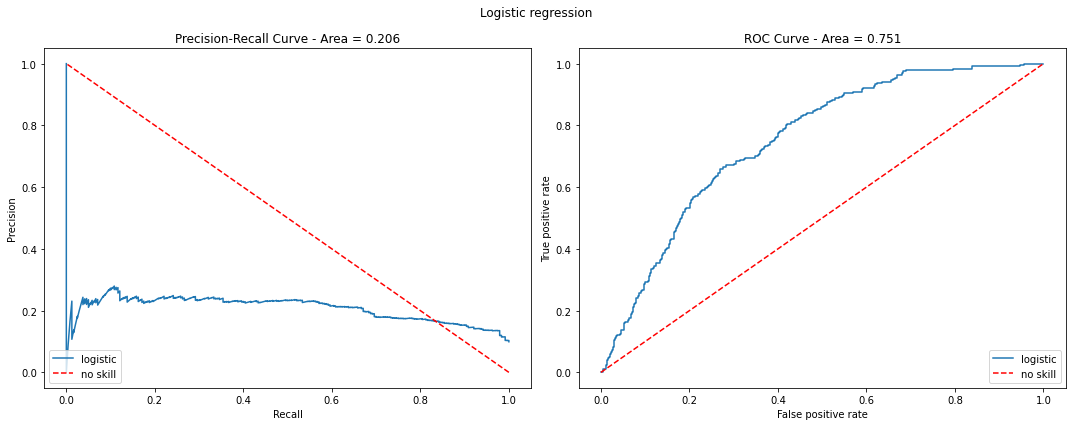

In [91]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

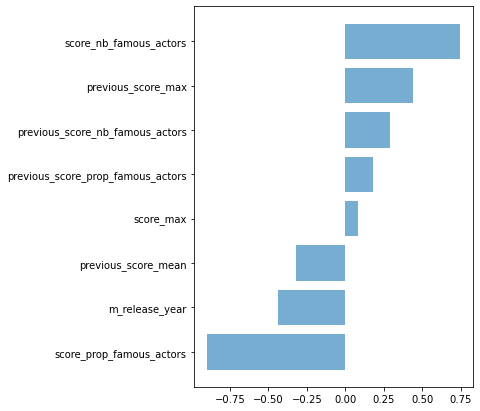

In [92]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 6. Stay in the loop

## 6.1 Load the yearly numbers dataset

In [93]:
SCORE_YEARLY_PATH = os.path.join(DATA_PATH, 'numbers_yearly.tsv')
df_numbers_yearly=pd.read_csv(SCORE_YEARLY_PATH, sep="\t")
df_numbers_yearly['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_numbers_yearly.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,lifetime_score,m_release_date
0,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,414.0,2001-08-24
1,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0,1593.0,2001-08-24


In [94]:
df_numbers_yearly.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,lifetime_score,m_release_date
0,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,414.0,2001-08-24
1,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0,1593.0,2001-08-24


In [95]:
columns = df_numbers_yearly.columns[1:]

In [96]:
df_loop = df_chars_merged.loc[(df_chars_merged['already_revealed']==1) & (df_chars_merged['nb_years_acting']>=1)].sort_values(['actor_name', 'm_release_date']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.drop(columns, axis=1, inplace=True)
df_loop = df_loop.merge(df_numbers_yearly, on='actor_name', how='left').copy()
df_loop.dropna(subset=['actor_gender'], inplace=True)
df_loop.head()

KeyError: 'nb_years_acting'

In [ ]:
df_loop['actor_gender'].value_counts()

In [ ]:
def get_score_year(row):
    release_year = row['m_release_date'].year
    return int(row['{}'.format(release_year)] > 0)

In [ ]:
df_loop['still_ranked'] = df_loop.apply(lambda row: get_score_year(row), axis=1)

In [ ]:
df_loop['is_main_actor'] = (df_loop['score_max'] == df_loop['min_year_score']).astype(int)

In [ ]:
df_loop['is_main_actor'].sum()

In [ ]:
df_loop['still_ranked'].sum()

In [ ]:
df_loop[df_loop['still_ranked'] == 1]['is_main_actor'].sum()

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
#df_loop.drop_duplicates('wikipedia_m_ID', keep='first', inplace=True)

In [ ]:
df_loop['wikipedia_m_ID'].nunique()

In [ ]:
df_loop.groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='M'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender']=='F'].groupby('still_ranked')[list_columns+['is_main_actor']].mean()

In [ ]:
sns.histplot(data=df_loop,x='actor_gender',hue='still_ranked', cumulative=False, multiple='fill', stat='proportion')
plt.grid();

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='score_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='F_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop,x='actor_gender',y='M_max', hue='still_ranked')

In [ ]:
df_tmp = df_loop.dropna()
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['M_max'], df_tmp[df_tmp['still_ranked']==0]['M_max'])

In [ ]:
ttest_ind(df_tmp[df_tmp['still_ranked']==1]['F_max'], df_tmp[df_tmp['still_ranked']==0]['F_max'])